In [1]:
import sys
sys.path.append("/home/vblot/multiaccurate_cp/")

In [2]:
import os
import yaml

import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
from mapie.multi_label_classification import MapieMultiLabelClassifier
from scipy import integrate
from scipy.optimize import minimize
from tqdm import tqdm

from multiaccurate_cp.utils.multiaccurate import J, J_prime

%load_ext autoreload
%autoreload 2

In [3]:
BASE_DIR = "/home/vblot/multiaccurate_cp/data/aerial"
MODELS_PATH = "/home/vblot/multiaccurate_cp/data/aerial/03_model_weights/resnet"


In [4]:
IMG_SIZE = 64
UNET_EMBEDDING_SIZE = 512

In [5]:
DIR_CAL_PRED_PROBAS = os.path.join(BASE_DIR, "04_predictions/cal/pred_probas")
DIR_CAL_LABELS = os.path.join(BASE_DIR, "02_prepared_data/cal/labels")
DIR_RES_PRED_PROBAS = os.path.join(BASE_DIR, "04_predictions/res/pred_probas")
DIR_RES_LABELS = os.path.join(BASE_DIR, "02_prepared_data/res/labels")
DIR_TEST_PRED_PROBAS = DIR_CAL_PRED_PROBAS.replace("cal", "test")
DIR_TEST_LABELS = DIR_CAL_LABELS.replace("cal", "test")

DIR_CAL_UNET_EMB = os.path.join(BASE_DIR, "04_predictions/cal/embeddings",)
DIR_RES_UNET_EMB = DIR_CAL_UNET_EMB.replace("cal", "res")
DIR_TEST_UNET_EMB = DIR_CAL_UNET_EMB.replace("cal", "test")



In [6]:
def load_data_old(pred_probas_dir, res_emb_dir, unet_emb_dir, labels_dir):
    pred_probas = np.zeros((len(os.listdir(pred_probas_dir)), IMG_SIZE, IMG_SIZE))
    res_emb = np.zeros((len(os.listdir(res_emb_dir)), RESNET_EMBEDDING_SIZE))
    unet_emb = np.zeros((len(os.listdir(unet_emb_dir)), UNET_EMBEDDING_SIZE))
    labels = np.zeros((len(os.listdir(labels_dir)), IMG_SIZE, IMG_SIZE))

    for i, (pred_proba_file, res_emb_file, unet_emb_file, label_file) in enumerate(
        tqdm(zip(
            sorted(os.listdir(pred_probas_dir)),
            sorted(os.listdir(res_emb_dir)),
            sorted(os.listdir(unet_emb_dir)),
            sorted(os.listdir(labels_dir))
        ))
    ):
        pred_proba = np.load(os.path.join(pred_probas_dir, pred_proba_file))
        pred_probas[i] = cv2.resize(pred_proba, (IMG_SIZE, IMG_SIZE))
        res_emb[i] = np.load(os.path.join(res_emb_dir, res_emb_file))
        unet_emb[i] = np.load(os.path.join(unet_emb_dir, unet_emb_file))
        label = cv2.imread(os.path.join(labels_dir, label_file), cv2.IMREAD_GRAYSCALE) / 255
        labels[i] = cv2.resize(label, (IMG_SIZE, IMG_SIZE)) > .5    
    return pred_probas, res_emb, unet_emb, labels


def load_data(list_pred_probas, list_unet_emb, list_labels):
    pred_probas = np.zeros((len(list_pred_probas), IMG_SIZE, IMG_SIZE))
    unet_emb = np.zeros((len(list_unet_emb), UNET_EMBEDDING_SIZE))
    labels = np.zeros((len(list_labels), IMG_SIZE, IMG_SIZE))

    for i, (pred_proba_file, unet_emb_file, label_file) in enumerate(
        tqdm(zip(
            list_pred_probas,
            list_unet_emb,
            list_labels,
        ))
    ):
        pred_proba = np.load(pred_proba_file)
        pred_probas[i] = cv2.resize(pred_proba, (IMG_SIZE, IMG_SIZE))
        unet_emb[i] = np.load(unet_emb_file)
        label = cv2.imread(label_file, cv2.IMREAD_GRAYSCALE) / 255
        labels[i] = cv2.resize(label, (IMG_SIZE, IMG_SIZE)) > .5    
    return pred_probas, unet_emb, labels

In [7]:
cal_pred_probas, cal_unet_emb, cal_labels = load_data(
    list_pred_probas=sorted(glob.glob(os.path.join(DIR_CAL_PRED_PROBAS, "*.npy")) + glob.glob(os.path.join(DIR_RES_PRED_PROBAS, "*.npy"))),
    list_unet_emb=sorted(glob.glob(os.path.join(DIR_CAL_UNET_EMB, "*.npy")) + glob.glob(os.path.join(DIR_RES_UNET_EMB, "*.npy"))),
    list_labels=sorted(glob.glob(os.path.join(DIR_CAL_LABELS, "*.tif")) + glob.glob(os.path.join(DIR_RES_LABELS, "*.tif")))
)


3000it [02:52, 17.34it/s]


In [8]:
test_pred_probas, test_unet_emb, test_labels = load_data(
    list_pred_probas=sorted(glob.glob(os.path.join(DIR_TEST_PRED_PROBAS, "*.npy"))),
    list_unet_emb=sorted(glob.glob(os.path.join(DIR_TEST_UNET_EMB, "*.npy"))),
    list_labels=sorted(glob.glob(os.path.join(DIR_TEST_LABELS, "*.tif")))
)

0it [00:00, ?it/s]

2300it [01:45, 21.76it/s]


In [20]:
index_not_empy = np.where(cal_labels.sum(axis=(1, 2)) > 0)[0]
cal_labels = cal_labels[index_not_empy]
cal_pred_probas = cal_pred_probas[index_not_empy]
cal_unet_emb = cal_unet_emb[index_not_empy]

len(cal_labels), len(test_labels)

(2458, 2300)

100%|██████████| 5/5 [00:00<00:00, 11.70it/s]


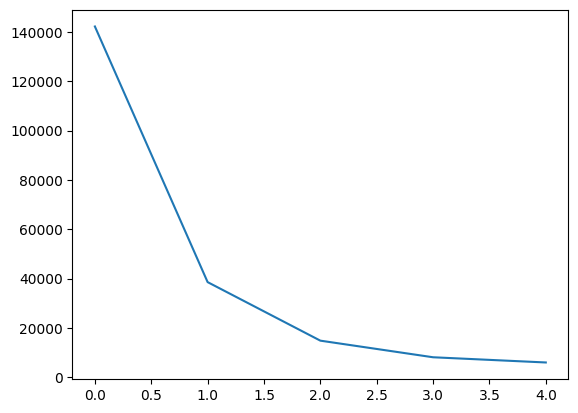

In [21]:
# create clustering with the embeddings and show the intra cluster variance according to the nb of clusters

from sklearn.cluster import KMeans

max_clusters = 6
intra_cluster_variance = np.zeros(max_clusters)
for n_clusters in tqdm(range(1, max_clusters)):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(cal_unet_emb)
    intra_cluster_variance[n_clusters] = kmeans.inertia_

plt.plot(intra_cluster_variance[1:])



In [65]:
N_CLUSTERS = 5
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=0).fit(cal_unet_emb)

cal_clusters_dist = kmeans.transform(cal_unet_emb)
test_clusters_dist = kmeans.transform(test_unet_emb)

# normalize the distances
cal_clusters_dist = cal_clusters_dist / cal_clusters_dist.sum(axis=1)[:, None]
test_clusters_dist = test_clusters_dist / test_clusters_dist.sum(axis=1)[:, None]


In [66]:
ALPHA = .1
N = len(cal_labels)
REGULARIZATION = "ridge"

In [54]:
def grid_search_lambda(labels, pred_probas, embeddings, embedding_size):
    lambdas = [0, 0.001, 0.01, 0.1, 0.2, 0.5, 0.7, 1]
    best_dist = np.inf
    best_lambda = None
    cv = len(lambdas)
    # get cv indices
    indices = np.arange(len(labels))
    np.random.seed(42)
    np.random.shuffle(indices)
    indices = np.array_split(indices, cv)
    for i, lambda_ in enumerate(tqdm(lambdas)):
        test_labels = labels[indices[i]]
        test_pred_probas = pred_probas[indices[i]]
        test_res_emb = embeddings[indices[i]]
        cal_labels = np.concatenate([labels[indices[j]] for j in range(cv) if j != i])
        cal_pred_probas = np.concatenate([pred_probas[indices[j]] for j in range(cv) if j != i])
        cal_res_emb = np.concatenate([embeddings[indices[j]] for j in range(cv) if j != i])
        
        result = minimize(
            J, np.random.uniform(0, 1, embedding_size),
            method="SLSQP",
            args=(cal_labels, cal_pred_probas, cal_res_emb, ALPHA, len(cal_labels), REGULARIZATION, lambda_), jac=J_prime,
            options={"disp": False, "maxiter": 10000}
        )
        ths = np.maximum((test_res_emb @ result.x).reshape(-1, 1, 1), 0.01)
        ths = (test_res_emb @ result.x).reshape(-1, 1, 1)
        test_res_emb.shape
        y_pred_test_th = (test_pred_probas >= ths).astype(int)
        recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))
        if (np.abs(recall_test - (1 - ALPHA))) < best_dist:
            best_dist = np.abs(recall_test - (1 - ALPHA))
            best_lambda = lambda_
        
    return best_lambda, best_dist
        

# Fit CRC

In [55]:
class MapieWrapper():
    def __init__(self):
        self.trained_ = True
        self.classes_ = 1

    def fit(self, X, y=None):
        pass

    def predict_proba(self, X):
        return X

    def predict(self, X):
        pred_proba = self.predict_proba(X)
        return pred_proba >= .5

    def __sklearn_is_fitted__(self):
        return True

In [56]:
mapie_crc = MapieMultiLabelClassifier(MapieWrapper(), method="crc")
for i in tqdm(range(len(cal_pred_probas))):
    X, y = cal_pred_probas[i], cal_labels[i]
    mapie_crc.partial_fit(X.ravel()[np.newaxis, :], y.ravel()[np.newaxis, :])

100%|██████████| 2458/2458 [00:02<00:00, 1162.90it/s]


In [57]:
_, _ = mapie_crc.predict(test_pred_probas.ravel()[np.newaxis, :], alpha=ALPHA)
th_crc = mapie_crc.lambdas_star
th_crc

array([0.2])

# Fit multi-accurante with UNet embedding

In [58]:
lambda_unet, dist_unet = grid_search_lambda(cal_labels, cal_pred_probas, cal_clusters_dist, N_CLUSTERS)
print(lambda_unet, dist_unet)
result_unet = minimize(
    J, np.random.uniform(0, 1, N_CLUSTERS),
    method="SLSQP",
    args=(cal_labels, cal_pred_probas, cal_clusters_dist, ALPHA, N, REGULARIZATION, lambda_unet), jac=J_prime,
    options={"disp": True, "maxiter": 1000}, tol=1e-10
)
ths_unet = (test_clusters_dist @ result_unet.x).reshape(-1, 1, 1)


  0%|          | 0/8 [00:00<?, ?it/s]

/tmp/ipykernel_1055246/2137850341.py:29: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))
100%|██████████| 8/8 [01:03<00:00,  7.88s/it]

0 0.0025776089025154603


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.968521748156407
            Iterations: 37
            Function evaluations: 56
            Gradient evaluations: 37


In [59]:
# ths_unet = np.maximum(ths_unet, 0.1)
ths_unet.min(), ths_unet.max()

(-0.0058307987013304545, 0.2952021579445409)

# Apply thresholds on pred-probas

In [60]:
y_pred_test_th_unet = (test_pred_probas >= ths_unet).astype(int)
recall_unet = (y_pred_test_th_unet * test_labels).sum(axis=(1, 2)) / test_labels.sum(axis=(1, 2))

y_pred_test_th_crc = (test_pred_probas >= th_crc).astype(int)
recall_test_crc = (y_pred_test_th_crc * test_labels).sum(axis=(1, 2)) / test_labels.sum(axis=(1, 2))

/tmp/ipykernel_1055246/446697216.py:2: RuntimeWarning: invalid value encountered in divide
  recall_unet = (y_pred_test_th_unet * test_labels).sum(axis=(1, 2)) / test_labels.sum(axis=(1, 2))
/tmp/ipykernel_1055246/446697216.py:5: RuntimeWarning: invalid value encountered in divide
  recall_test_crc = (y_pred_test_th_crc * test_labels).sum(axis=(1, 2)) / test_labels.sum(axis=(1, 2))


In [61]:
precision_test_unet = np.nan_to_num((y_pred_test_th_unet * test_labels).sum(axis=(1, 2)) / y_pred_test_th_unet.sum(axis=(1, 2)), nan=1)
precision_test_crc = np.nan_to_num((y_pred_test_th_crc * test_labels).sum(axis=(1, 2)) / y_pred_test_th_crc.sum(axis=(1, 2)), nan=1)


/tmp/ipykernel_1055246/1461555032.py:1: RuntimeWarning: invalid value encountered in divide
  precision_test_unet = np.nan_to_num((y_pred_test_th_unet * test_labels).sum(axis=(1, 2)) / y_pred_test_th_unet.sum(axis=(1, 2)), nan=1)
/tmp/ipykernel_1055246/1461555032.py:2: RuntimeWarning: invalid value encountered in divide
  precision_test_crc = np.nan_to_num((y_pred_test_th_crc * test_labels).sum(axis=(1, 2)) / y_pred_test_th_crc.sum(axis=(1, 2)), nan=1)


In [62]:
precision_test_unet = (y_pred_test_th_unet * test_labels).sum(axis=(1, 2)) / y_pred_test_th_unet.sum(axis=(1, 2))
precision_test_crc = (y_pred_test_th_crc * test_labels).sum(axis=(1, 2)) / y_pred_test_th_crc.sum(axis=(1, 2))


/tmp/ipykernel_1055246/1660610716.py:1: RuntimeWarning: invalid value encountered in divide
  precision_test_unet = (y_pred_test_th_unet * test_labels).sum(axis=(1, 2)) / y_pred_test_th_unet.sum(axis=(1, 2))
/tmp/ipykernel_1055246/1660610716.py:2: RuntimeWarning: invalid value encountered in divide
  precision_test_crc = (y_pred_test_th_crc * test_labels).sum(axis=(1, 2)) / y_pred_test_th_crc.sum(axis=(1, 2))


# Plot results

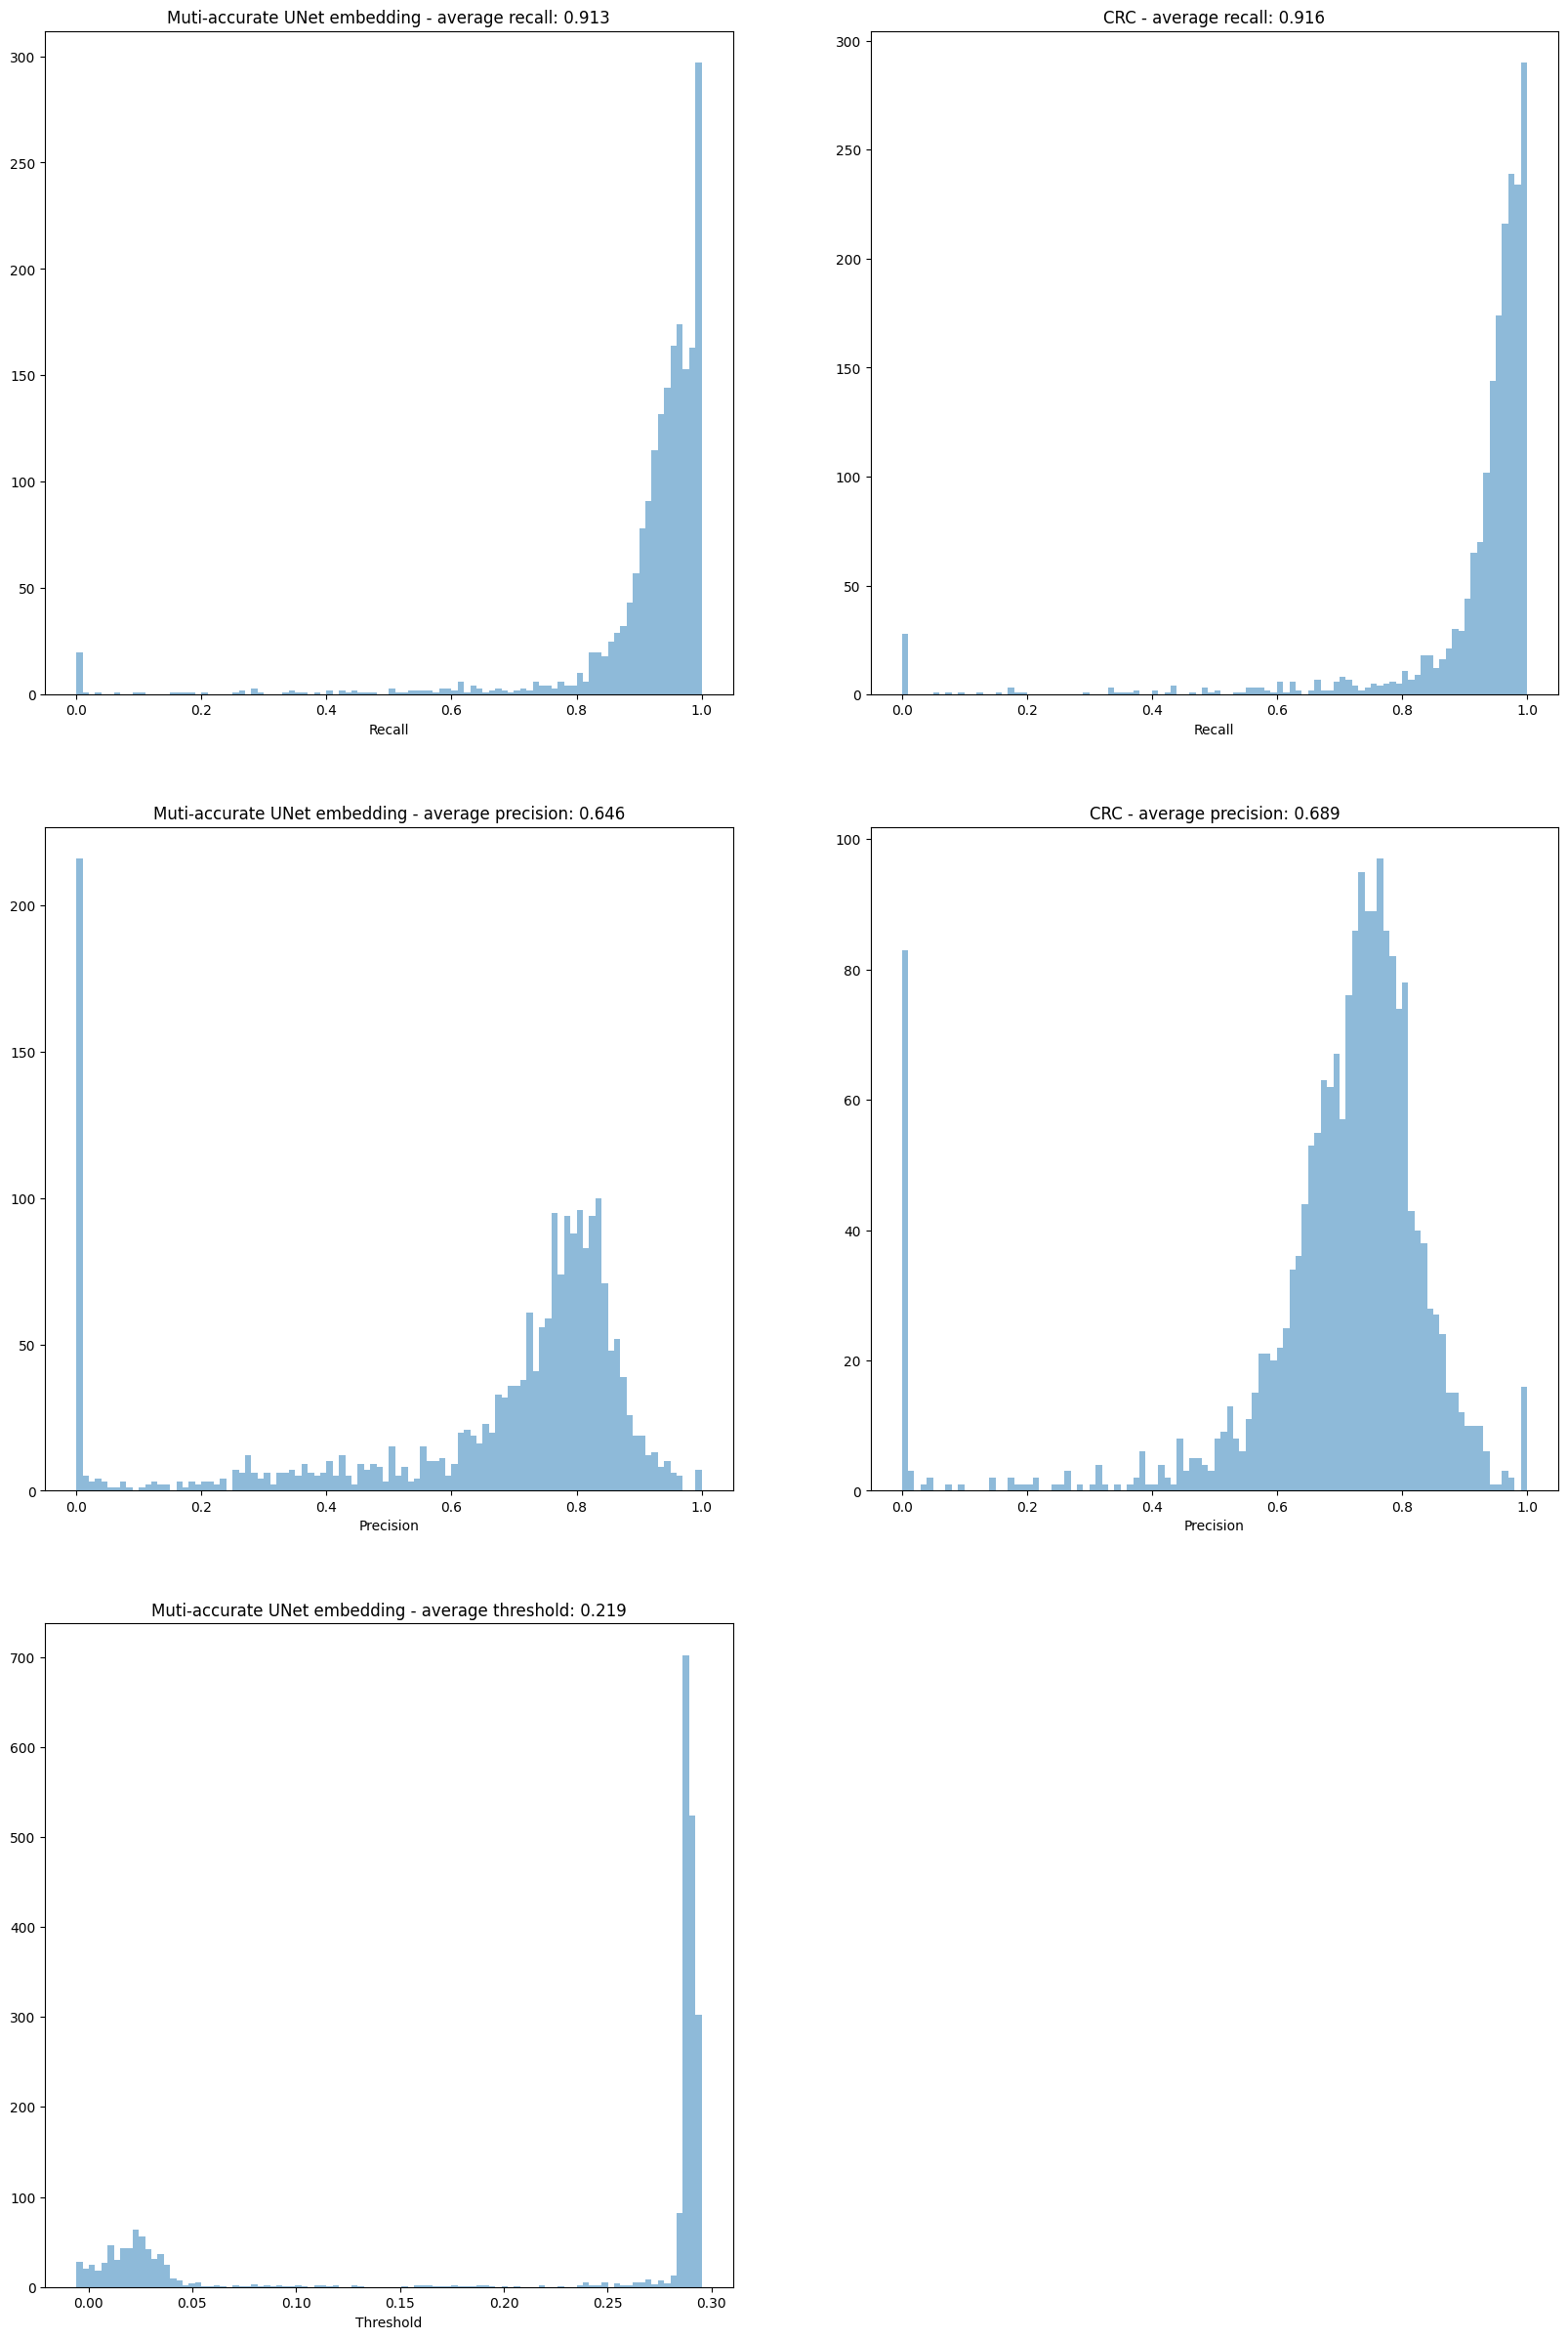

In [63]:
s = 10
nrow = 3
ncol = 2
f, ax = plt.subplots(nrow, ncol, figsize=(ncol * s, nrow * s))

ax[0, 0].hist(recall_unet, bins=100, alpha=.5)
ax[0, 0].set_title(f"Muti-accurate UNet embedding - average recall: {np.nanmean(recall_unet):.3f}")
ax[0, 0].set_xlabel("Recall")

ax[0, 1].hist(recall_test_crc, bins=100, alpha=.5)
ax[0, 1].set_title(f"CRC - average recall: {np.nanmean(recall_test_crc):.3f}")
ax[0, 1].set_xlabel("Recall")

ax[1, 0].hist(precision_test_unet, bins=100, alpha=.5)
ax[1, 0].set_title(f"Muti-accurate UNet embedding - average precision: {np.nanmean(precision_test_unet):.3f}")
ax[1, 0].set_xlabel("Precision")


ax[1, 1].hist(precision_test_crc, bins=100, alpha=.5)
ax[1, 1].set_title(f"CRC - average precision: {np.nanmean(precision_test_crc):.3f}")
ax[1, 1].set_xlabel("Precision")

ax[2, 0].hist(ths_unet[:, 0, 0], bins=100, alpha=.5)
ax[2, 0].set_title(f"Muti-accurate UNet embedding - average threshold: {np.nanmean(ths_unet):.3f}")
ax[2, 0].set_xlabel("Threshold")

ax[2, 1].set_axis_off()

In [39]:
precision_test_crc

array([0.70740741, 0.71220401, 0.76749436, ..., 0.43490305, 0.65946561,
       0.7114094 ])

In [23]:
precision_test_resnet

array([0.70740741, 0.7045045 , 0.76749436, ..., 0.43681319, 0.65946561,
       0.71227856])

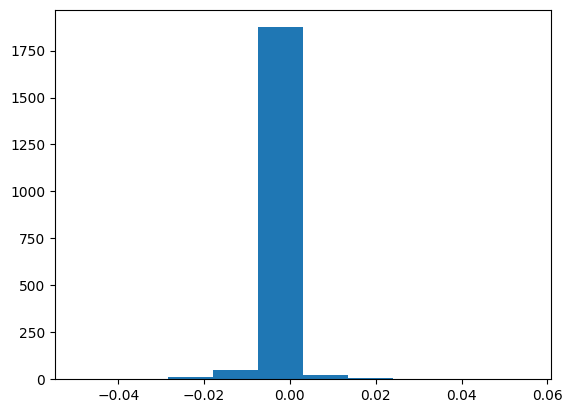

In [24]:
plt.hist(precision_test_resnet - precision_test_crc)
plt.show()

In [25]:
np.nanmean((precision_test_resnet - precision_test_crc))

-0.0012704638943564213

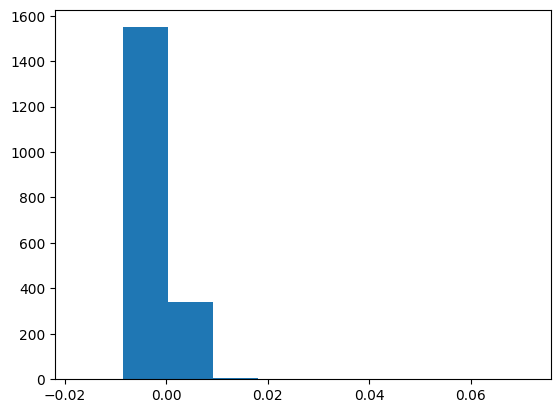

In [26]:
plt.hist(recall_resnet - recall_test_crc)
plt.show()

In [27]:
np.nanmean(precision_test_unet)
t_unet = []
for i in precision_test_unet:
    if i == 0:
        continue
    else:
        t_unet.append(i)

t_resnet = []
for i in precision_test_resnet:
    if i == 0:
        continue
    else:
        t_resnet.append(i)

t_crc = []
for i in precision_test_crc:
    if i == 0:
        continue
    else:
        t_crc.append(i)

np.nanmean(t_unet), np.nanmean(t_resnet), np.nanmean(t_crc)

(0.7384775916068159, 0.7022805341865256, 0.7036104666035967)

In [28]:
np.nanmean(t)

NameError: name 't' is not defined

In [ ]:
len(precision_test_unet)

2300